# Desarrollo

Al momento de implementar el modelo:

- Se definió que no realizaríamos data augmentation con la esperanza de que la red sepa aprovechar la semejanza que hay entre las imágenes: el pulmón izquierdo (a la derecha) es siempre menor al derecho, las opacidades pulmonares se encuentran siempre dentro de la caja torácica sobre los pulmones, etc. 

- Se decidió implementar el modelo en Google Colaboratory para poder trabajar en equipo a distancia sobre el mismo archivo, dado que se conocía que era posible.

- Se eligió trabajar con la implementación de Darknet adecuada para Google Colab de *kriyeng* [2]. Se partió de los pesos originales de *pjreddie*, el desarrollador de Darknet.

- El *thresh* es el umbral mediante el cual se decide si conservar o descartar una detección según su confidence. Por default, Darknet descarta las detecciones cuya confidence se encuentre por debajo de 0,25. Este umbral es seteable. El ganador de la competencia de Kaggle utilizó un valor de 0,15 para el umbral de la confidencia de una detección. Debido a que encontramos ese dato, decidimos setearlo el umbral a 0,15. Cabe aclarar que este umbral solo se utiliza luego del entrenamiento para validar el modelo.

Primero, se trabajó con imágenes de 256x256, siguiendo la recomendación de Jake Huneycutt [1] quien utilizó Darkflow (otra implementación de YOLO) para resolver este mismo problema y expresó que el uso de las imágenes con toda su resolución no producía una gran diferencia en la tasa de aciertos mientras que enlentecía notablemente el tiempo de procesamiento.

Se investigó esta afirmación y se encontraron muchas referencias a que cuanto mejor es la resolución de las imágenes, mejor es la tasa de aciertos. En paralelo, se implementó un segundo modelo con un dataset de imágenes de 1024x1024.

A raíz de lo explorado en el EDA, se interpretó erróneamente lo siguiente: la propiedad ViewPosition de los archivos DICOM es relevante ya que varía de qué lado se ve el corazón en la imagen. El pulmón izquierdo es de un tamaño anatómicamente menor debido a esto, lo cual debería ser tenido en cuenta al momento de entrenar la red. Dado que la posición posteroanterior es la recomendada, decidimos espejar los estudios tomados anteroposteriormente. Guardamos estas imágenes en una carpeta aparte y comenzamos a entrenar un nuevo modelo. Sin embargo, la ayudante Cande Mosquera nos explicó que habíamos interpretado mal la información, que no era necesario realizar el flip ya que en el momento en el cual se guarda la imagen se guarda en la orientación que corresponde. Los médicos necesitan saber si la radiografía fue AP o PA dado que según cómo está acostado el paciente, los órganos se distribuyen de forma diferente y es por esto que se tiene que informar esta característica, más no se debe realizar el flip a la hora de pre-procesar el dataset ya que eso ya esta hecho. 

Por otro lado, se estudió el trabajo de Austin Dorsey [3], quien utilizó YOLO v2 para detectar opacidades pulmonares con este mismo dataset. Dorsey utilizó únicamente aquellas imágenes de train que tenían opacidades pulmonares y obtuvo los mejores resultados que vimos para esta competencia. Por lo tanto, implementamos un modelo utilizando únicamente estas 6012 imágenes divididas en train y validation. Luego de dos días de entrenamiento, había realizado 8000 iteraciones y su loss no baja de 0,4 cuando el resto con ese estadío de entrenamiento tenían una loss del orden de 0,2, por lo que lo descartamos.

Luego de entrenar los dos modelos que conservábamos (uno de imágenes de 256x256 píxeles y otro de imágenes de 1024x1024, ambos con las 26.684 imágenes originales) durante más de 15.000 iteraciones hasta observar la presencia de signos de overfitting, intentamos realizar una submission en Kaggle. En ambas notebooks se presenta el proceso para realizarlo y se explica por qué desistimos. Luego, como habíamos utilizado la totalidad de nuestras imágenes etiquetadas para entrenar los modelos, no teníamos un subset de test para obtener las métricas finales.

Finalmente, corrimos un último modelo que es el que se presenta a continuación. Se entrenó con 22.681 imágenes en train, 2.682 imágenes en validation y 1.321 imágenes en test.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Prerrequisitos

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
import pandas as pd
from matplotlib import patches

## Clonado de Darknet

Estos comandos descargan los archivos del repositorio de kriyeng y los guardan en los archivos de esta notebook dentro de una carpeta titulada "darknet".

In [ ]:
!git clone https://github.com/kriyeng/darknet/
%cd darknet
!git checkout feature/google-colab

Cloning into 'darknet'...
remote: Enumerating objects: 10068, done.
remote: Total 10068 (delta 0), reused 0 (delta 0), pack-reused 10068
Receiving objects: 100% (10068/10068), 10.15 MiB | 6.60 MiB/s, done.
Resolving deltas: 100% (6735/6735), done.
/content/darknet
Branch 'feature/google-colab' set up to track remote branch 'feature/google-colab' from 'origin'.
Switched to a new branch 'feature/google-colab'


Este comando compila la arquitectura. Si se desea hacer alguna modificación a los archivos que componen al flujo de Darknet, debe realizarse antes de correr este comando (o volver a correrlo luego de realizar el cambio). De esta manera, la ejecución automática tomará estos archivos.

In [ ]:
!make

chmod +x *.sh


Es recomendable a la hora de utilizar Darknet, hacer transfer learning. Esto se debe a su uso para detección de objetos. Inicializar la red con un set de pesos que corresponden a una red que detecta objetos de forma efectiva permite que el tiempo de procesamiento necesario para solucionar el problema se reduzca. Utillizamos los pesos oficiales de Joseph Redmon.

In [ ]:
#!wget https://pjreddie.com/media/files/darknet53.conv.74

--2020-07-18 05:56:02--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  2.34MB/s    in 70s     

2020-07-18 05:57:13 (2.21 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



## Inicialización de las variables de dirección de archivos
A lo largo del trabajo, se accede a los archivos subidos a Google Drive. Se inicializan como variables para simplificar. El archivo cfg varía en que en esta implementación, se realiza data augmentation. Las imágenes se rotan +/- 10 grados, y se agrega un max_crop y un min_crop de 32 píxeles. 

In [ ]:
objdata = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng-imagenes1024/dataContainer/obj_data_final.txt'
yolov3cfg = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng-imagenes1024/dataContainer/yolo-obj5.cfg'
preweights = '/content/darknet/darknet53.conv.74'

Durante el entrenamiento, Darknet guarda los pesos actuales cada 100 interaciones en el archivo que llama *last_weights* y crea un nuevo archivo de pesos cada 1000 interaciones. Esto fue sumamente importante ya que correr una red neuronal en Colab implica que cada 12 hs es necesario reconectar a la GPU a distancia, que si se tienen fluctuaciones en la conexión a internet se desconecta y que posee un límite de uso de GPU por cuenta. Debido a que se contaba con estas instancias intermedias del estado de los pesos, era posible retomar el entrenamiento casi sin pérdida de información e incluso desde otra cuenta con acceso a estos archivos de backup. Aquí se tienen los archivos generados con el entrenamiento de esta notebook:

In [ ]:
backup_dir = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng-imagenes1024/dataContainer/backup_final/'
last_weights = backup_dir + '/yolo-obj5_last.weights'
weights1k = backup_dir + '/yolo-obj3_1000.weights'
weights2k = backup_dir + '/yolo-obj3_2000.weights'
weights3k = backup_dir + '/yolo-obj3_3000.weights'
weights4k = backup_dir + '/yolo-obj3_4000.weights'
weights5k = backup_dir + '/yolo-obj3_5000.weights'
weights6k = backup_dir + '/yolo-obj5_6000.weights'
weights7k = backup_dir + '/yolo-obj5_7000.weights'
weights8k = backup_dir + '/yolo-obj5_8000.weights'

Para la instancia de testeo, hay que utilizar un nuevo *objdata* que lleve a las direcciones de las imágenes de test. Luego, para poder mostrar imágenes con sus predicciones y sus anotaciones, se inicializa la dirección de la carpeta de Google Drive donde se tienen las imágenes de 1024x1024 con sus anotaciones.

In [ ]:
objdatatest = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng-imagenes1024/dataContainer/obj_data_final_test.txt'
images_dir = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng-imagenes1024/dataContainer/data/obj/'

#Train

## Train with pjreddie's weights

Este comando es utilizado para empezar a entrenar la red. Luego, cuando el entrenamiento se interrumpa ya sea por algún problema técnico o simplemente porque Google Colab se reinicia cada 12 hs, se retoma el entrenamiento con el comando siguiente.

In [ ]:
#!./darknet detector train '$objdata' '$yolov3cfg' '$preweights' -dont_show

Se truncaron las últimas líneas 5000 del resultado de transmisión.
 402: 0.628833, 0.522568 avg loss, 0.000026 rate, 9.717403 seconds, 25728 images
Loaded: 0.000058 seconds

 403: 0.569243, 0.527236 avg loss, 0.000026 rate, 9.821432 seconds, 25792 images
Loaded: 0.000036 seconds

 404: 0.768606, 0.551373 avg loss, 0.000027 rate, 9.812253 seconds, 25856 images
Loaded: 0.000034 seconds

 405: 0.538800, 0.550116 avg loss, 0.000027 rate, 9.753977 seconds, 25920 images
Loaded: 0.000063 seconds

 406: 0.632974, 0.558401 avg loss, 0.000027 rate, 9.717676 seconds, 25984 images
Loaded: 0.000036 seconds

 407: 0.495851, 0.552146 avg loss, 0.000027 rate, 9.678972 seconds, 26048 images
Loaded: 0.000046 seconds

 408: 0.619032, 0.558835 avg loss, 0.000028 rate, 9.672633 seconds, 26112 images
Loaded: 0.000032 seconds

 409: 0.717061, 0.574658 avg loss, 0.000028 rate, 9.721091 seconds, 26176 images
Loaded: 0.000037 seconds

 410: 0.751031, 0.592295 avg loss, 0.000028 rate, 9.720588 seconds, 26240 ima

## Train with last weights

Este comando se utiliza para retomar el entrenamiento. Parte de los últimos pesos guardados.

In [ ]:
# Start training at the point where the last runtime finished
!./darknet detector train '$objdata' '$yolov3cfg' '$last_weights' -dont_show

yolo-obj5
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32 0.639 BF
   1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64 3.407 BF
   2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32 0.379 BF
   3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128 3.407 BF
   6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
   7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
  10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256 3.407 BF
  13 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128 0.379

##Matriz de confusión para los pesos:

# Validation

Este comando evalúa el modelo utilizando el subset de validation. Al igual que en los anteriores, se le indica la posición de los archivos que necesita, con la diferencia de que éste se utiliza para comparar la performance del modelo en distintos estadíos de su entrenamiento. Para esto, se utilizan los archivos de pesos que corresponden a distinto número de iteraciones. 

El output de esta evaluación es un bloque de texto con información cuantitativa. El primer número *detections_count* es el número de detecciones en las 4004 imágenes de validation. Cabe aclarar que puede haber más de una detección por imagen. El segundo número *unique_truth_count* corresponde al número de opacidades que *efectivamente había* en el subset de validation. El *class_id* es siempre 0 ya que la única clase de objetos detectados es "Lung Opacity". El valor *ap* corresponde a la precisión promedio y se vuelve a indicar como el *mAP* (mean average precision), calculado con un umbral de 0,5. Las siglas *TP* y *FP* corresponden a verdaderos y falsos positivos respectivamente, mientras que *FN* son los falsos negativos. El *average IoU* indicado se calcula con los verdaderos positivos por lo que de ser nulos, este indicador será siempre nulo. 

Este paso es crucial ya que la elección del estadío de entrenamiento es un hiperparámetro a definir. Deben compararse los resultados obtenidos en validation para los distintos estadíos para poder seleccionar aquel que tenga una mejor performance en validation, es decir cuyo valor de mAP sea mayor.

In [ ]:
!./darknet detector map '$objdata' '$yolov3cfg' '$last_weights' -thresh 0.15

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32 0.639 BF
   1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64 3.407 BF
   2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32 0.379 BF
   3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128 3.407 BF
   6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
   7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
  10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256 3.407 BF
  13 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128 0.379 BF
  14 c

## Valores de mAP para distintos estadíos


En el afán de mejor las métricas obtenidas, se estudió el efecto de la modificación del umbral de confidence mencionado. El *mAP* no resultó muy sensible a estas modificaciones, mientras que el IoU sí. 

El hecho de que el mAP en validation comience a bajar notablemente a partir de las 9000 iteraciones mientras que el average loss disminuía indica que a partir de entonces, el modelo comenzaba a presentar overfitting.

A continuación, se presentan las métricas obtenidas indicado a qué instancia de entrenamiento corresponden:

Iteraciones | mAP | threshold | Average IoU | TP | FP
------------- | ------------- | ------------- | ------------- | ------------- | -------------
1000 | 0,053853 | 0,15 | 0,1959 | 4 | 8 
2000 | 0,138917 | 0,15 | 0 | 0 | 0
3000 | 0,111472 | 0,15 | 0 | 0 | 0
4000 | 0,089023 | 0,15 | 0 | 0 | 0
5000 | 0,169981 | 0,15 | 0,4472 | 8 | 3
6000 | 0,164160 | 0,15 | 0,1642 | 0 | 1
7000 | 0,112598 | 0,15 | 0,1802 | 114 | 278
8000 | 0,120414 | 0,15 | 0,4331 | 4 | 2
8700 | 0,096903 | 0,15 | 0,7187 | 1 | 0





##Matriz de confusión

Presentamos como ejemplo la matriz de confusión de los pesos correspondientes a 5000 iteraciones, con un threshold de 0.15:

- Especificidad: 0.7273
- Sensibilidad: 0.5021

modelo/anotaciones | Verdaderos Positivos | Verdadero Negativo 
------------- | ------------- | ------------- 
Positivo | 8 | 3  
Negativo | 946 | 954 

# Test
Para concluir el modelo, se calculan las métricas de evaluación utilizando las imágenes del subset de test. Para esto, se utiliza el *objdatatest* que indica las direcciones a estas imágenes y sus etiquetas. El estadío de entrenamiento (weights) utilizado es el resultante del análisis de performance en validation.

In [ ]:
!./darknet detector map '$objdatatest' '$yolov3cfg' '$weights5k' -thresh 0.15

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32 0.639 BF
   1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64 3.407 BF
   2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32 0.379 BF
   3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128 3.407 BF
   6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
   7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
  10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256 3.407 BF
  13 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128 0.379 BF
  14 c

##mAP y Matriz de confusión

***El mAP en el subset de Test fue de 0,1693***. Presentamos la matriz de confusión obtenida con los pesos correspondientes a 5000 iteraciones, con un threshold de 0,15 en el subset de test:

- Especificidad: 0.50
- Sensibilidad: 0.7640


modelo/anotaciones | Verdaderos Positivos | Verdadero Negativo 
------------- | ------------- | ------------- 
Positivo | 3 | 3  
Negativo | 465 | 1505 

# Exploración de resultados

Al estudiar la submission obtenida como se detalló, no se obtuvieron los resultados esperados. Originalmente, se observó que los bounding boxes parecían ***fuera de escala***. 

Se arribó a esta conclusión debido a que en todos los casos donde la red detecta opacidades pulmonares, éstas se encuentran siempre en la esquina superior izquierda de la imagen y tienen un área ligeramente inferior. En caso de ser más de una, se observa que su posición se asemeja a la posición de los pulmones. Aquí cabe destacar que las anotaciones de opacidades pulmonares en el subset de train (que nuestras predicciones deberían imitar) están etiquetadas abarcando una gran proporción de los pulmones. 

Dado que la documentación de Darknet no es exhaustiva, desconocíamos cuál era el código que debíamos revisar. No encontramos ninguna publicación en internet de alguien que se haya encontrado con un problema con la escala aparente de los bounding boxes. Sin embargo, estudiando los archivos de Darknet, dentro de la carpeta *src*, se tiene el archivo *image.c* donde hay está la función *draw_detections_v3* donde se puede acceder a las coordenadas de los bounding boxes y luego, éstas pueden imprimirse. Estudiando los resultados de imprimir las coordenadas de todas las predicciones correspondientes al subset de test, se confirmó nuestra conclusión anterior de que la totalidad de las bounding boxes predecidas no superaban los 700 píxeles de ancho y alto. 

Sin embargo, con la orientación de Cande Mosquera, nos dimos cuenta que el hecho de que ninguna de *esas* bounding boxes que estábamos estudiando superase los 700 píxeles no aseguraba que nuestro modelo no pudiese indicar detecciones en el área restante de la imagen. 

El ganador de la competencia de Kaggle utilizó un valor de 0,15 para el umbral de la confidencia de una detección. Debido a que encontramos ese dato y con el valor default no se detectaba prácticamente ninguna opacidad, decidimos setearlo el umbral a 0,15. Para testear nuestra teoría que un problema de escalas, redujimos el umbral a cero. Como era de esperarse, se detectaron opacidades a lo largo de toda la imagen, lo cual nos llevó a rechazar nuestra hipótesis original.

Al correr el comando de test para una imagen, se crea de forma automática archivo .jpg en la carpeta de contenidos titulado "predictions.jpg". Se crearon dos funciones que utilizan esta imagen para explorar los resultados obtenidos

## Umbral de confidencia nulo
A continuación, se elige una imagen aleatoria de test y se predicen opacidades pulmonares son un umbral de confidence mínima de 0. Como esperado, se observa que la imagen resultante está cubierta de predicciones, demostrando que el modelo no tiene una limitación espacial para la detección de opacidades.

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0%
Lung Opacity: 0

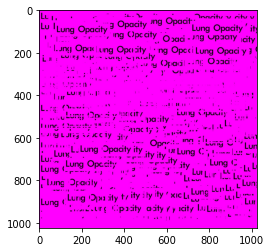

In [ ]:
img_dir = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng-imagenes1024/dataContainer/data/obj/06b52ffd-71b8-429a-a284-bb39240ed343.jpg'

!./darknet detector test '$objdatatest' '$yolov3cfg' '$weights5k' '$img_dir' -thresh 0 -dont_show

prediction = cv2.imread('predictions.jpg')
prediction = cv2.cvtColor(prediction, cv2.COLOR_BGR2RGB)
plt.imshow(prediction)

Al correr con un umbral ligeramente mayor, se observa que se detectan muchas más opacidades en la imagen pero sobre todo, que estas no se encuentran confinadas en la esquina superior izquierda de la misma.

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32 0.639 BF
   1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64 3.407 BF
   2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32 0.379 BF
   3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128 3.407 BF
   6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
   7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
  10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256 3.407 BF
  13 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128 0.379 BF
  14 c

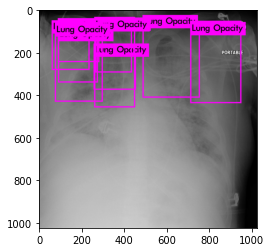

In [ ]:
!./darknet detector test '$objdatatest' '$yolov3cfg' '$weights5k' '$img_dir' -thresh 0.001 -dont_show

prediction = cv2.imread('predictions.jpg')
prediction = cv2.cvtColor(prediction, cv2.COLOR_BGR2RGB)
plt.imshow(prediction)

## Actual versus predicted
Esta función solo puede utilizarse con imágenes etiquetadas. En este caso, se tienen imágenes de test etiquetadas. En la misma imagen, se presenta la predicción del modelo como recuadros color rosa y las anotaciones de los profesionales en radiología como recuadros verdes.

In [ ]:
def ActualvsPredict(patientid):
  image_loc = images_dir + patientid + '.jpg'
  result = !./darknet detector test '$objdatatest' '$yolov3cfg' '$weights5k' '$image_loc' -thresh 0.15 -dont_show
  print(result)
                   
  newImage = cv2.imread('predictions.jpg')
  newImage = cv2.cvtColor(newImage, cv2.COLOR_BGR2RGB)
  #add axes to the image
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.axis('off')

  # read and plot the image
  annotations = pd.read_csv('/content/drive/My Drive/Final_redes/RN__TP_Final/stage_2_train_labels.csv')
  image = newImage
  plt.imshow(image)

  # iterating over the image for different objects
  for index,row in annotations[annotations.patientId == patientid].iterrows():
            
      edgecolor = 'g'
      ax.annotate('Annotated', xy=(row.x-40,row.y+20))
          
      # add bounding boxes to the image
      rect = patches.Rectangle((row.x,row.y), row.width, row.height, edgecolor = edgecolor, facecolor = 'none')
      
      ax.add_patch(rect)

Se muestran las predicciones para imágenes del subset de test que tienen opacidades anotadas para poder ilustrar cómo predice nuestro modelo.

['layer     filters    size              input                output', '   0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32 0.639 BF', '   1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64 3.407 BF', '   2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32 0.379 BF', '   3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64 3.407 BF', '   4 Shortcut Layer: 1', '   5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128 3.407 BF', '   6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF', '   7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF', '   8 Shortcut Layer: 5', '   9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF', '  10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF', '  11 Shortcut Layer: 8', '  12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256 3.407 BF', '  13 conv    128  1 x 1 / 1    76 x  76 

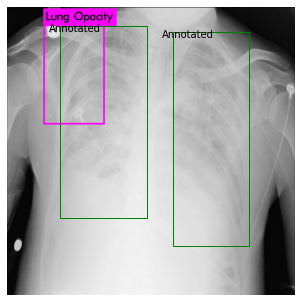

In [ ]:
ActualvsPredict('0c8458d8-25e6-44e5-946e-cf729240df59')

['layer     filters    size              input                output', '   0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32 0.639 BF', '   1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64 3.407 BF', '   2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32 0.379 BF', '   3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64 3.407 BF', '   4 Shortcut Layer: 1', '   5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128 3.407 BF', '   6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF', '   7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF', '   8 Shortcut Layer: 5', '   9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF', '  10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF', '  11 Shortcut Layer: 8', '  12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256 3.407 BF', '  13 conv    128  1 x 1 / 1    76 x  76 

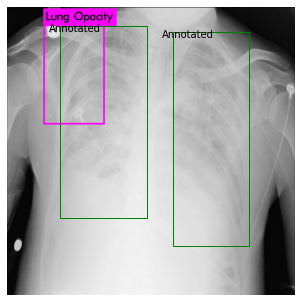

In [ ]:
ActualvsPredict('0c8458d8-25e6-44e5-946e-cf729240df59')

# Discusión

## La conclusión a la cual se arriba es que el modelo desarrollado no soluciona el problema.

Esto puede atribuirse a múltiples razones. Para empezar, la detección de opacidades pulmonares no es trivial. Radiólogos de años de experiencia concluyen clasificaciones distintas al presentársele el mismo estudio radiológico, e incluso de llegar a la misma, encuadran la opacidad de forma diferente, priorizando que ninguna porción de opacidad quede por fuera del encuadro o bien buscando que la totalidad del área del recuadro contenga opacidad sin importar que esto implique que quede una porción de la opacidad fuera del recuadro. También es importante destacar que los límites de estas opacidades tampoco son claros. El hecho de que el dataset utilizado para entrenar a la red haya sido etiquetado por distintos profesionales puede comprometer el entrenamiento.

Sin embargo, el modelo no fue capaz siquiera de devolver detecciones que se encuentren restringidas a la delimitación de los pulmones. La gran mayoría de las opacidades detectadas se encuentra sobre el hombro del paciente. Como se ve en los resultados presentados, hay una cierta superposición de las opacidades detectadas con las etiquetas anotadas a la cual se le atribuye el valor de mAP obtenido como métrica de evaluación del modelo. Esta superposición se descarta ya que las detecciones no corresponden a opacidades pulmonares (a pesar de que al disminuir el umbral de confidencia a valores ínfimos y obtener detecciones sobre estas opacidades, ninguna contiene una opacidad en su totalidad).

Hipotetizamos que el modelo encontró que poniendo las bounding boxes en esta posición, conseguía disminuir la función de costo, lo que indica que fracasó en la verdadera detección del objeto. Que haya elegido ubicar a la gran mayoría de sus detecciones en la esquina superior izquierda puede tener que ver con que en las imágenes de radiografía de tórax, el pulmón derecho del paciente se ve a la izquierda de la imagen y éste es notablemente más grande en volúmen. Esto hace que sea más probable detectar opacidades en el pulmón derecho que en el izquierdo (recordar el heatmap presentado en la exploración analítica de los datos). Nuestra decisión de no realizar data augmentation partía de esta idea, pero no eran estos los resultados que esperábamos. En retrospectiva, hubiese sido mejor realizar data augmentation desde un principio y evitar que el modelo arribe a esta solución únicamente por la posición espacial más usual de las anotaciones. Sin embargo, una vez que realizamos data augmentation para este último modelo, no se notó una mejora. Cabe destacar que este último modelo no fue entrenado tanto tiempo como los otros, pero el hecho de que el mAP en validation ya haya empezado a bajar indica que muy probablemente ya se encuentra en estado de overfitting.

Al encarar el trabajo, decidimos otorgar el 85% de las imágenes disponibles a train, lo que corresponde a un total de 22.681 imágenes. Este número de imágenes parecía ser suficiente. A su vez, contábamos con la certeza de que habían sido suficientes para los participantes de la competencia. Solamente 5.110 de estas imágenes poseen opacidades pulmonares. Es posible que los resultados mejoren si se dispusiese de un mayor número de imágenes etiquetadas con opacidades pulmonares para el entrenamiento.

Creemos que continuar con el entrenamiento no hubiese ayudado al problema ya que se observó que a pesar de que la loss seguía bajando, también lo hacía el valor del mAP en validation.

Por último, si decidiésemos entrenar un nuevo modelo para solucionar este problema, dudaríamos de hacerlo con Darknet e incluso dudaríamos de hacerlo con YOLO. La decisión de elegir esta arquitectura para implementar este modelo se basó en la popularidad que tiene. Los resultados publicados de modelos basados en YOLO son impresionantes. Priorizan el tiempo de procesamiento sacrificando el accuracy. Al encarar el trabajo, razonamos que dado que se conceptualizaba como una posible herramienta de diagnóstico, sería apropiado que la detección se realizase en tiempo real. En retrospectiva, priorizar el tiempo de procesamiento en la primera implementación no fue una buena decisión ya que se encuentra en una etapa muy temprana del desarrollo del proyecto.

# Bibliografía

[1] Huneycutt, J. (2018) *YOLO Object Detection Walkthrough for the RSNA Pneumonia Detection Challenge*. Good Audience.

[2] *Yolo-v3 and Yolo-v2 for Windows and Linux*. Available on: https://github.com/kriyeng/darknet/.

[3] Austin Dorsey. *Pneumonia Detection: Object detection utilizing YOLOv3 and OpenCV to detect pneumonia in a chest scan*. Available on: http://austindorsey.com/Projects/PneumoniaDetection.html.